In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

from io import StringIO
import sys

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_n9x1lads.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


### Model creation:

In [2]:
# Data Preparation
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[10,1,10], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 
geo_data.delete_surfaces('rock1',remove_data=True)
geo_data.delete_surface_points([1,3,4,5])
geo_data.modify_surface_points([0, 2], Y=500, Z=[500, 600])

Active grids: ['regular']


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,500,0.2501,0.5001,0.46885,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.53135,rock2,Default series,1,1,1.000000e-08


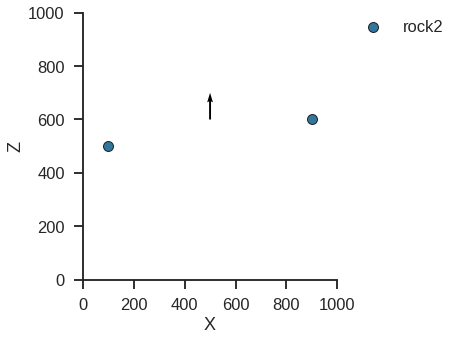

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
geo_data.interpolator.get_python_input_block()[6].shape

(100, 3)

In [5]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=['compare', 'relu'])

Compiling theano function...
Compilation Done!


In [6]:
gp.compute_model(geo_data);

n_surface_0 __str__ = [[0.]]
a __str__ = 1.3927127
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8123463
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8123463
n_surface_1 __str__ = [[0.]]
b __str__ = 0.09997714
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [5.2445661e-03 4.0410282e-03 2.8385425e-03 1.6358489e-03 4.3124318e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.4592812e-03 4.2554969e-03 3.0525560e-03 1.8490236e-03 6.4290821e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.6644166e-03 4.4583362e-03 3.2527449e-03 2.0461695e-03 8.3654519e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.8596605e-03 4.6488927e-03 3.4379642e-03 2.2255820e-03 1.0100126e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 6.0466980e-03 4.8292000e-03 3.6105956e-03 2.3899912e-03 1.1664360e-03
 0.0000000e+00 0.0000000e+00 0.000

In [8]:
geo_data.interpolator.theano_graph.sig_slope.set_value(np.array(50, dtype='float32'))

<IPython.core.display.Javascript object>


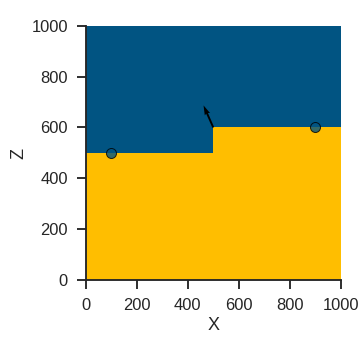

In [35]:
%matplotlib notebook
gp.plot.plot_section(geo_data, 0, show_data=True)
#gp.plot.plot_scalar_field(geo_data, 0, plot_data=False)

<IPython.core.display.Javascript object>


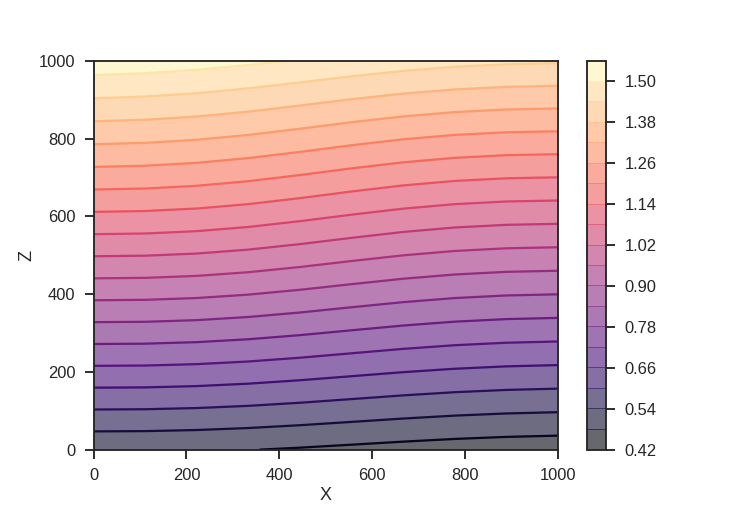

In [51]:
gp.plot.plot_scalar_field(geo_data, 0, plot_data=False)
plt.colorbar()

In [61]:
geo_data.solutions.scalar_field_matrix.reshape(10,10).max(), geo_data.solutions.scalar_field_matrix.reshape(10,10).min()

(1.5363692, 0.4441804)

<IPython.core.display.Javascript object>


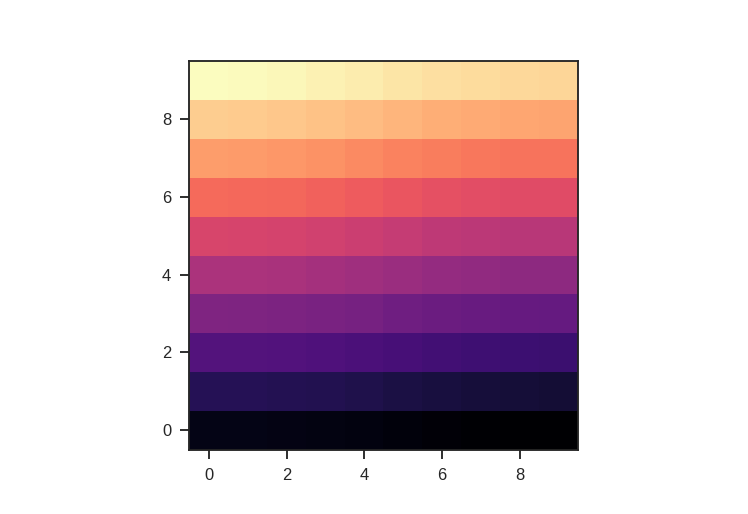

In [54]:
plt.imshow(geo_data.solutions.scalar_field_matrix.reshape(10,10).T - a[1], cmap='magma', 
          origin='lower')

## Plotting the sigmoid function:

In [38]:
# Cleaning buffer
old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

# Computing model
gp.compute_model(geo_data)

# Black magic update
sys.stdout = old_stdout

# Split print strings
output = mystdout.getvalue().split('\n')

# Init parameters
n_surface_op_float_sigmoid = []
n_surface_0 = []
n_surface_1 = []
a = []
b = []
drift = []
relu_up = []
relu_down = []

activ = False
activ_d = False
aux_str = ''
aux_str_d = ''

for s in output:
    if 'n_surface_op_float_sigmoid __str__' in s:
        n_surface_op_float_sigmoid.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_0 __str__' in s:
        n_surface_0.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_1 __str__' in s:
        n_surface_1.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'a __str__' in s:
        a.append(float(s[s.find('= ')+2:]))
    if 'b __str__' in s:
        b.append(float(s[s.find('= ')+2:]))
    if 'drift[slice_init:slice_init+1][0] __str__' in s:
        drift.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'ReLU_up __str__' in s or activ:
        activ = True
        find_c = s.find(']')
        if find_c != -1:
            activ = False
            l_1 = -1
        else:
            l_1 = 10000
        
        l_0 = int(s.find('[')+1)
        aux_str += (s[l_0:l_1])        
  
    
    if 'ReLU_down __str__' in s or activ_d:
        activ_d = True
        find_c = s.find(']')
        if find_c != -1:
            activ_d = False
            l_1 = -1
        else:
            l_1 = 10000
        
        l_0 = int(s.find('[')+1)
        aux_str_d += (s[l_0:l_1])   

relu_down.append(np.fromstring(aux_str_d, dtype='float', sep=' '))
relu_up.append(np.fromstring(aux_str, dtype='float', sep=' '))
  
a, b, n_surface_0, n_surface_1, drift#, relu_up, relu_down

([1.547291, 1.2174891],
 [1.2174891, 0.4332585],
 [array([0.]), array([2.])],
 [array([1.]), array([0.])],
 [array([1.]), array([2.])])

In [14]:
relu = relu_up[0] + relu_down[0]
relu;


<IPython.core.display.Javascript object>


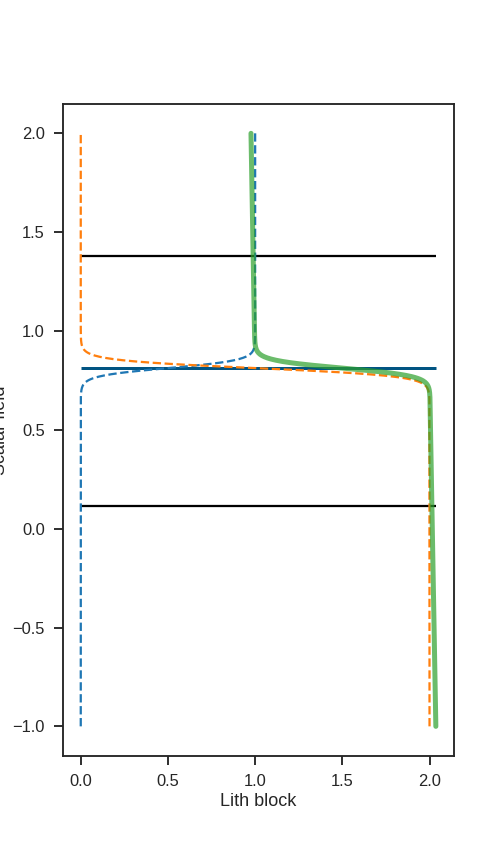

In [15]:
from gempy.utils.gradient import plot_sig
relu = relu_down+ relu_up
plot_sig(n_surface_0[:], n_surface_1, a, b, drift, Z_x = np.linspace(-1,2,2000),
         sf_max=geo_data.solutions.scalar_field_matrix.max(),
         sf_min=geo_data.solutions.scalar_field_matrix.min(),
         sf_at_scalar=geo_data.solutions.scalar_field_at_surface_points[0],
        relu =relu);

In [ ]:
break

In [ ]:
a = np.arange(10)
b= np.copy(a)
a, b

In [ ]:
%debug

### Calculating the jacobian

We are going to recompile so we do not print all the sigmoid values when we use `gp.compute model`

In [78]:
# gp.set_interpolation_data(geo_data, theano_optimizer='fast_run',
#                          verbose=[])

Compiling theano function...
Compilation Done!


In any case, since the gradient is not yet implemented in gempy we need to recompile it appart. For this demo we will compute the jacobian of each of our lith_block respect the surface points: `geo_data.interpolator.theano_graph.input_parameters_loop[4]`

In [16]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_j = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.jacobian((geo_data.interpolator.theano_graph.compute_series()[0][-1][:100]), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

Respect: All the surface_points points at once


We compute it:

In [17]:
geo_data.interpolator.theano_graph.sig_slope.set_value(np.array(50, dtype='float32'))

In [29]:
geo_data.modify_orientations(0, dip=330, azimuth=130)

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,500,500,600,0.5001,0.5001,0.53135,-0.383022,0.321394,0.866025,330,130,1,rock2,Default series,1,1,0.01


In [30]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4

ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-03 3.1277912e-03
 2.0201551e-03 9.0712070e-04 0.0000000e+00 0.0000000e+00 

a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.000000

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-03 3.1277912e-03
 2.0201551e-03 9.0712070e-04 0.0000000e+00 0.0000000e+00 

b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-0

b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-0

n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0

ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-03 3.1277912e-03
 2.0201551e-03 9.0712070e-04 0.0000000e+00 0.0000000e+00 

ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5056693e-03 6.3684573e-03 5.2358313e-03 4.1085584e-03 2.9864877e-03
 1.8679750e-03 7.5000880e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.5830189e-03 6.4611160e-03 5.3452090e-03 4.2348150e-03 3.1277912e-03
 2.0201551e-03 9.0712070e-04 0.0000000e+00 0.0000000e+00 

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.0000000e+00 0.0000000e+00 0.000000

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

n_surface_0 __str__ = [[0.]]
a __str__ = 1.547291
n_surface_1 __str__ = [[1.]]
b __str__ = 1.2174891
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.2174891
n_surface_1 __str__ = [[0.]]
b __str__ = 0.4332585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
ReLU_down __str__ = [7.2760968e-03 6.0914350e-03 4.9044620e-03 3.7179415e-03 2.5356268e-03
 1.3619935e-03 2.0134688e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.2828992e-03 6.0987780e-03 4.9128029e-03 3.7281285e-03 2.5491314e-03
 1.3808738e-03 2.2766231e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3107588e-03 6.1316839e-03 4.9515367e-03 3.7735503e-03 2.6022659e-03
 1.4427411e-03 2.9866933e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.3603606e-03 6.1915908e-03 5.0231740e-03 3.8579528e-03 2.6997370e-03
 1.5524017e-03 4.1809081e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.4280002e-03 6.2740259e-03 5.1224814e-03 3.9753341e-03 2.8346712e-03
 1.7018878e-03 5.7664514e-04 0.00000

The shape of the result will be:

In [58]:
jac[:, 0,:]

array([[-1.49621069e-03,  2.79464433e-03,  1.89617313e-02],
       [-1.29413418e-03,  2.41629267e-03,  1.94495991e-02],
       [-1.12080132e-03,  2.06935871e-03,  1.99958608e-02],
       [-9.89570515e-04,  1.78200752e-03,  2.06037648e-02],
       [-9.54860821e-04,  1.70082599e-03,  2.24234052e-02],
       [-9.64552909e-03,  2.09562927e-02,  2.51828909e-01],
       [-8.72014046e-01,  1.49484396e+00,  2.15805588e+01],
       [-5.68056554e-02,  6.75117970e-02,  1.24199724e+00],
       [-1.47594884e-03,  1.95546914e-03,  3.00666392e-02],
       [-1.29503035e-03,  1.86891970e-03,  2.44891234e-02],
       [-7.57265603e-04,  2.00186903e-03,  1.59201138e-02],
       [-4.78886534e-04,  1.68075552e-03,  1.63989179e-02],
       [-2.36222753e-04,  1.39176194e-03,  1.69144683e-02],
       [-4.93950211e-05,  1.15925493e-03,  1.74698848e-02],
       [ 6.01431821e-05,  1.09616062e-03,  1.90292485e-02],
       [ 1.00232661e-04,  1.44552365e-02,  2.03218505e-01],
       [ 2.40266323e-02,  9.64665413e-01

In [59]:
np.abs(jac).min(), np.abs(jac).max()

(1.0695541e-05, 21.580559)

- With ReLU 0.1 and slope 50 jac.min-max = 5.75e-05, 12.13 dip 0, azi = 90
- With ReLU 0.01 and slope 50 jac.min-max = 2.83e-06 11.93 dip 0, azi = 90

- With ReLU 0.01 and slope 50 jac.min-max = 2.83e-06 11.93 dip 30, azi = 130

where axis 0 (100) is the number of cells (2 is the number of surface points), axis 1 (2) is respect the 2 surface points and axis 2 (3) XYZ.

<IPython.core.display.Javascript object>


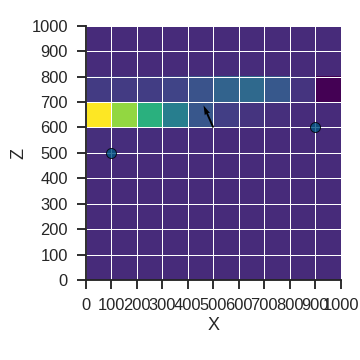

In [60]:
%matplotlib notebook
point = 0

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

If we plot the gradient respect the point 0 (left), we can observe that the high rate changes are concentrated around the interface line of the two surfaces. Also since the model is simetric we can expect the same gradient for the other point:

<IPython.core.display.Javascript object>


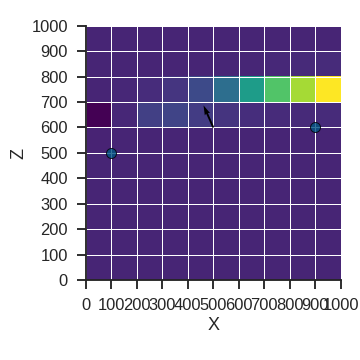

In [56]:
point = 1

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

### Gradient?

In [ ]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad((geo_data.interpolator.theano_graph.compute_series()[0][-1]).sum(), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

In [ ]:
grad = th_f_g(*geo_data.interpolator.get_python_input_block())